In [1]:
from config import*
from Helmholtz import*
from Wfamily import*
from Model import*

/envs/common/lib/python3.12/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/envs/common/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


family_len:  21316


In [ ]:
WPINN_model = WPINN(input_size = n_collocation, 
                    num_hidden_layers1 = 2, 
                    num_hidden_layers2 = 6, 
                    hidden_neurons = 50, 
                    family_size = len_family).to(device)

optimizer1 = optim.Adam(WPINN_model.parameters(), lr=1e-4)


def lr_lambda(epoch):
    if epoch < 25000: return 1.0      # Keeps LR at 1e-4
    else: return 0.1                  # LR becomes 1e-5

scheduler = optim.lr_scheduler.LambdaLR(optimizer1, lr_lambda=lr_lambda)


In [3]:
x_interior = x_collocation.clone()
y_interior = y_collocation.clone()
def wpinn_loss(model):   
    # PDE loss at collocation points

    global c,b
    c, b = model(x_interior, y_interior)

    u = torch.mv(Wfamily, c) + b
    u_yy = torch.mv(DW2y, c)
    u_xx = torch.mv(DW2x, c)
    
    u_pred_bc_left = torch.mv(Wbc_left, c) + b
    u_pred_bc_right = torch.mv(Wbc_right, c) + b
    u_pred_bc_bottom = torch.mv(Wbc_bottom, c) + b
    u_pred_bc_top = torch.mv(Wbc_top, c) + b
    
    pde_loss = torch.mean((u_yy + u_xx + u - rhs) ** 2)
    
    bc_loss = torch.mean((u_pred_bc_left - u_bc_left) ** 2) +\
              torch.mean((u_pred_bc_right - u_bc_right) ** 2) +\
              torch.mean((u_pred_bc_bottom - u_bc_bottom) ** 2) + \
              torch.mean((u_pred_bc_top - u_bc_top) ** 2)
    
    # Total loss with optional weighting
    total_loss = pde_loss + bc_loss
    
    return total_loss, pde_loss, bc_loss

def train_wpinn(model, optimizer, num_epochs, num_prints):

    for epoch in tqdm(range(num_epochs)):
        
        optimizer.zero_grad()
        total_loss, pde_loss, bc_loss = wpinn_loss(model)
        
        total_loss.backward()
        optimizer.step()
        scheduler.step()
    
        if epoch % ((num_epochs-1)/num_prints) == 0:  # Print every num_prints epochs
            numerical = torch.mv(Wval, c.cpu()) + b.cpu()
            errL2 = (torch.sum(torch.abs(exact_validation-numerical)**2))**0.5 / (torch.sum(torch.abs(exact_validation)**2))**0.5
            errMax = torch.max(torch.abs(exact_validation-numerical))

            print(f'Epoch [{epoch}/{num_epochs}], '
                f'Total Loss: {total_loss.item():.6f}, '
                f'PDE Loss: {pde_loss.item():.6f}, '
                f'BC Loss: {bc_loss.item():.6f}\n\t\t'
                f'RelativeL2: {errL2},\t\t'
                f'Max: {errMax}\n' )
            
        # torch.cuda.empty_cache()
            
        

In [4]:
torch.cuda.empty_cache()

num_epochs = 4*10**4+1
num_prints = 10
train_wpinn(WPINN_model, optimizer1, num_epochs, num_prints)

  0%|          | 0/40001 [00:00<?, ?it/s]

  0%|          | 22/40001 [00:00<06:07, 108.81it/s]

Epoch [0/40001], Total Loss: 111066.804688, PDE Loss: 111065.765625, BC Loss: 1.038555
		RelativeL2: 1.4039793014526367,		Max: 1.6076792478561401



 10%|█         | 4020/40001 [00:33<04:51, 123.64it/s]

Epoch [4000/40001], Total Loss: 2.323084, PDE Loss: 2.319075, BC Loss: 0.004009
		RelativeL2: 0.0125501099973917,		Max: 0.056305576115846634



 20%|██        | 8022/40001 [01:06<04:25, 120.65it/s]

Epoch [8000/40001], Total Loss: 2.283406, PDE Loss: 2.283119, BC Loss: 0.000286
		RelativeL2: 0.0038277781568467617,		Max: 0.02159302309155464



 30%|███       | 12023/40001 [01:40<03:57, 117.91it/s]

Epoch [12000/40001], Total Loss: 0.355984, PDE Loss: 0.355934, BC Loss: 0.000050
		RelativeL2: 0.0015743941767141223,		Max: 0.012419719249010086



 40%|████      | 16021/40001 [02:13<03:21, 119.14it/s]

Epoch [16000/40001], Total Loss: 0.526698, PDE Loss: 0.526673, BC Loss: 0.000024
		RelativeL2: 0.0011510548647493124,		Max: 0.00904126837849617



 50%|█████     | 20021/40001 [02:47<02:45, 120.54it/s]

Epoch [20000/40001], Total Loss: 0.131969, PDE Loss: 0.131954, BC Loss: 0.000015
		RelativeL2: 0.0008512514177709818,		Max: 0.006668437272310257



 60%|██████    | 24021/40001 [03:21<02:15, 117.77it/s]

Epoch [24000/40001], Total Loss: 0.057122, PDE Loss: 0.057111, BC Loss: 0.000011
		RelativeL2: 0.0005874683847650886,		Max: 0.005122561007738113



 70%|███████   | 28021/40001 [03:54<01:39, 120.50it/s]

Epoch [28000/40001], Total Loss: 0.000342, PDE Loss: 0.000334, BC Loss: 0.000008
		RelativeL2: 0.00042605053749866784,		Max: 0.0038302578032016754



 80%|████████  | 32021/40001 [04:28<01:07, 117.76it/s]

Epoch [32000/40001], Total Loss: 0.004072, PDE Loss: 0.004067, BC Loss: 0.000005
		RelativeL2: 0.000313810131046921,		Max: 0.002258557826280594



 90%|█████████ | 36021/40001 [05:01<00:33, 120.42it/s]

Epoch [36000/40001], Total Loss: 0.001040, PDE Loss: 0.001036, BC Loss: 0.000004
		RelativeL2: 0.0002610603696666658,		Max: 0.0016171671450138092



100%|██████████| 40001/40001 [05:35<00:00, 119.37it/s]

Epoch [40000/40001], Total Loss: 0.013112, PDE Loss: 0.013108, BC Loss: 0.000003
		RelativeL2: 0.0003741738910321146,		Max: 0.0012629665434360504



In [ ]:
# Additional cofficient refinement

c_trained = c
b_trained = b

coef_refinement_model = CoefficientRefinementNetwork(initial_coefficients=c_trained, initial_bias = b_trained).to(device)
optimizer2 = optim.Adam(coef_refinement_model.parameters(), lr = 0.1e-4)

num_epochs = 10**4+1
num_prints = 10
train_wpinn(coef_refinement_model, optimizer2, num_epochs, num_prints)

RelativeL2: 0.0003353800275363028,		 Max: 0.003357372945174575



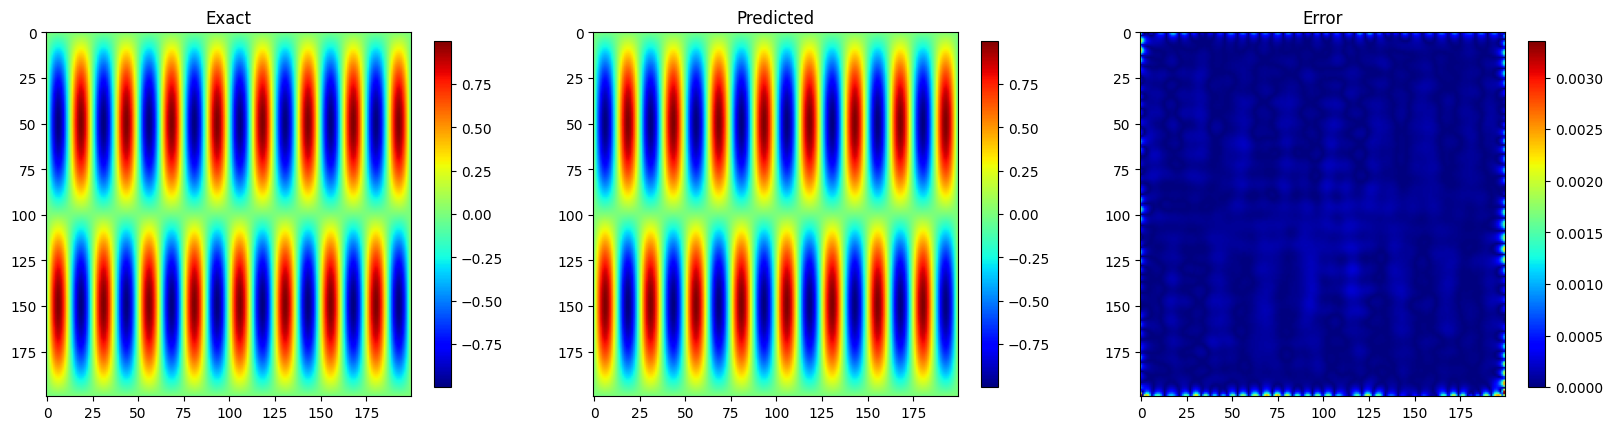

In [5]:
#  Testign and Plotting
u_pred = (torch.mv(Wtest, c.cpu()) + b.cpu()).reshape(n_test, n_test).detach().numpy()


errL2 = (np.sum(np.abs(exact_test-u_pred)**2))**0.5 / (np.sum(np.abs(exact_test)**2))**0.5
errMax = np.max(np.abs(exact_test-u_pred))


print(f'RelativeL2: {errL2},\t\t', f'Max: {errMax}\n' )

fig = plt.figure(1, figsize=(20,15))
plt.subplot(1,3,1)
plt.imshow(exact_test, cmap='jet')
plt.colorbar(shrink=0.3)
plt.title('Exact')

plt.subplot(1,3,2)
plt.imshow(u_pred, cmap='jet')
plt.colorbar(shrink=0.3)
plt.title('Predicted')

plt.subplot(1,3,3)
plt.imshow(abs(exact_test-u_pred), cmap='jet')
plt.colorbar(shrink=0.3)
plt.title('Error')

plt.savefig('sol.png')
plt.show()
